## Image segmentation with CamVid

In [1]:
!curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   665  100   665    0     0   3136      0 --:--:-- --:--:-- --:--:--  3136
    100% |████████████████████████████████| 5.7MB 6.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 589.3MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61e8a000 @  0x7f7777c2c2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
Cloning into 'course-v3'...
remote: Enumerating objects: 2232, done.
remote: Total 2232 (delta 0), re

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_06270.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08055.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_006900.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f02790_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02610_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_04770_P.png')]

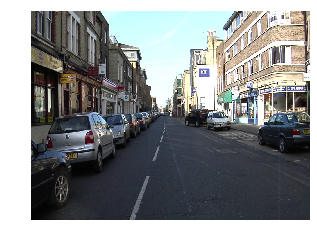

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

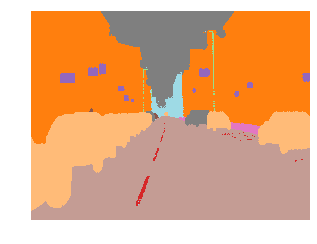

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [0]:
size = src_size//2
bs=8

In [0]:
src = (ImageFileList.from_folder(path_img)
       .label_from_func(get_y_fn)
       .split_by_fname_file('../valid.txt'))

In [0]:
data = (src.datasets(SegmentationDataset, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

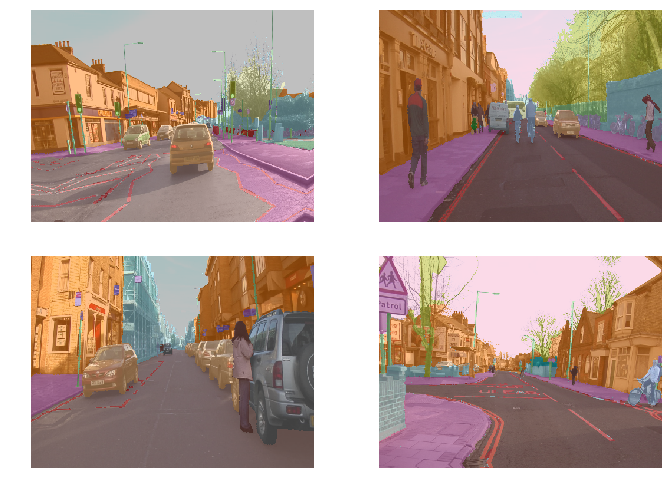

In [15]:
data.show_batch(2, figsize=(10,7))

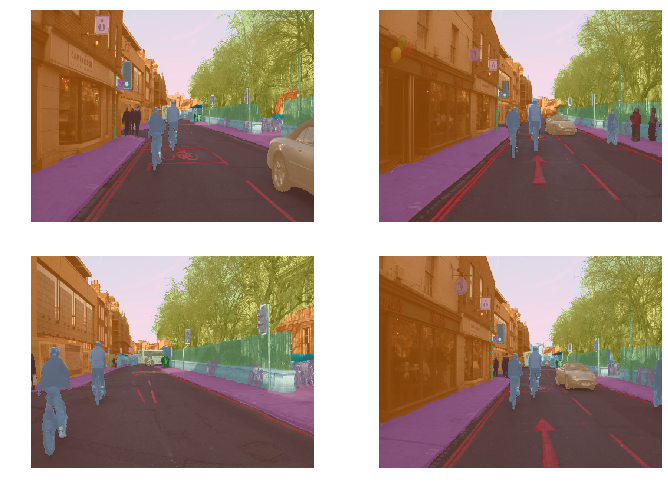

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [19]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 46737773.33it/s]


LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


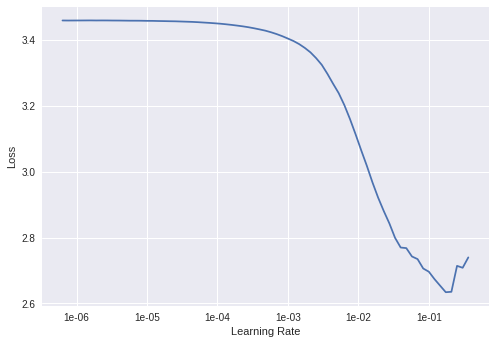

In [20]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-2

In [22]:
learn.fit_one_cycle(10, slice(lr))

Total time: 10:31
epoch  train_loss  valid_loss  acc_camvid
1      1.522293    nan         0.000000    (01:10)
2      0.890867    nan         0.000000    (01:02)
3      0.724495    nan         0.000000    (01:01)
4      0.651593    nan         0.000000    (01:02)
5      0.602893    nan         0.000000    (01:02)
6      0.545596    nan         0.000000    (01:01)
7      0.492098    nan         0.000000    (01:03)
8      0.459892    nan         0.000000    (01:03)
9      0.422391    nan         0.000000    (01:01)
10     0.406205    nan         0.000000    (01:01)



In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


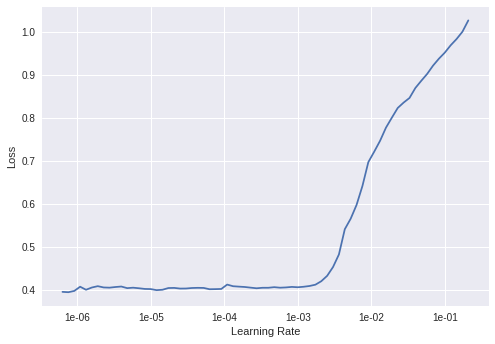

In [26]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lrs = slice(1e-5,lr/5)

In [28]:
learn.fit_one_cycle(12, lrs)

Total time: 13:11
epoch  train_loss  valid_loss  acc_camvid
1      0.401105    nan         0.000000    (01:05)
2      0.406258    nan         0.000000    (01:07)
3      0.408442    nan         0.000000    (01:07)
4      0.397646    nan         0.000000    (01:05)
5      0.397223    nan         0.000000    (01:05)
6      0.391593    nan         0.000000    (01:05)
7      0.366190    nan         0.000000    (01:05)
8      0.351848    nan         0.000000    (01:04)
9      0.335376    nan         0.000000    (01:05)
10     0.327915    nan         0.000000    (01:08)
11     0.315537    nan         0.000000    (01:06)
12     0.314584    nan         0.000000    (01:04)



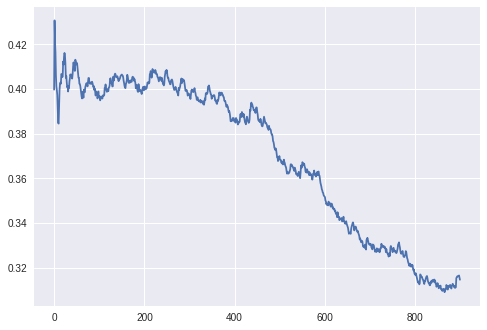

In [29]:
learn.recorder.plot_losses()

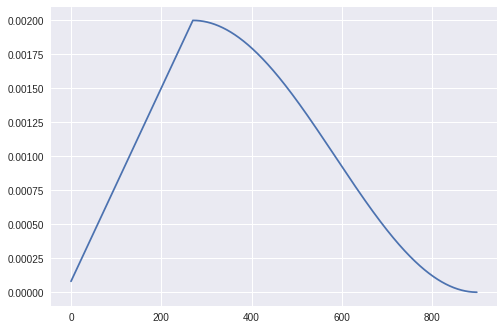

In [30]:
learn.recorder.plot_lr()

In [0]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
size = src_size
bs=4

In [0]:
data = (src.datasets(SegmentationDataset, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [0]:
learn.load('stage-2');

In [0]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid


In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr))

Total time: 08:44
epoch  train_loss  valid_loss  acc_camvid
1      0.454597    0.349557    0.900428    (01:02)
2      0.418897    0.351502    0.897495    (00:51)
3      0.402104    0.330255    0.906775    (00:50)
4      0.385497    0.313330    0.911832    (00:51)
5      0.359252    0.297264    0.916108    (00:52)
6      0.335910    0.297875    0.917553    (00:50)
7      0.336133    0.305602    0.913439    (00:51)
8      0.321016    0.305374    0.914063    (00:51)
9      0.311554    0.299226    0.915997    (00:51)
10     0.308389    0.301060    0.915253    (00:51)



In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr)

In [0]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

Total time: 09:30
epoch  train_loss  valid_loss  acc_camvid
1      0.323283    0.300749    0.915948    (00:56)
2      0.329482    0.290447    0.918337    (00:56)
3      0.324378    0.298494    0.920271    (00:57)
4      0.316414    0.296469    0.918053    (00:56)
5      0.305226    0.284694    0.920893    (00:57)
6      0.301774    0.306676    0.914202    (00:57)
7      0.279722    0.285487    0.919991    (00:57)
8      0.269306    0.285219    0.920963    (00:57)
9      0.260325    0.284758    0.922026    (00:57)
10     0.251017    0.285375    0.921562    (00:57)



In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big')

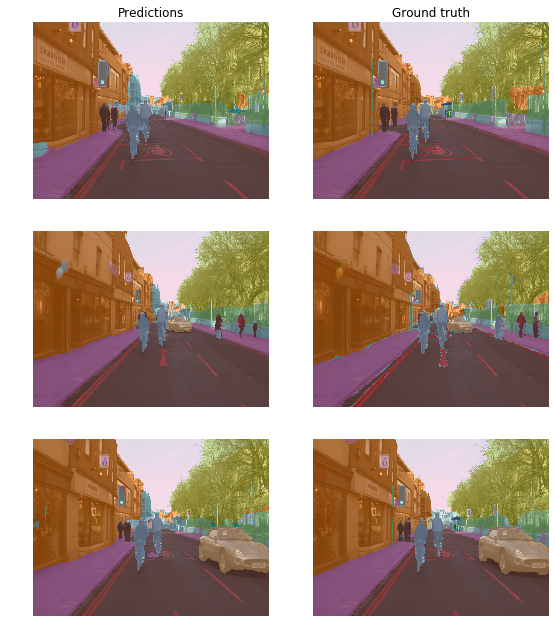

In [0]:
learn.show_results()